## Imports

In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("mandril.ipynb"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

import numpy as np
import gym
import torch
import json
import numpy as np
from tqdm import trange

import maml_rl.envs
from maml_rl.baseline import LinearFeatureBaseline
from maml_rl.samplers import MultiTaskSampler
from maml_rl.utils.helpers import get_policy_for_env, get_input_size
from maml_rl.utils.reinforcement_learning import get_returns, reinforce_loss

from mazelab import MazeEnv
from mazelab.solvers import dijkstra_solver

In [2]:
def show_maze(maze, title=None):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(maze)
    if title:
        plt.title(title)
    plt.show()

In [3]:
with np.load("../maml-randomShapeMaze/results.npz") as data_file:
    logs = {
        "tasks": data_file["tasks"],
        "train_returns" : data_file["train_returns"],
        "valid_returns" : data_file["valid_returns"],
        # "train_episodes" : data_file["train_episodes"],
        # "valid_episodes" : data_file["valid_episodes"],
    }

In [4]:
display(logs["tasks"].shape)
display(logs["train_returns"].shape)
display(logs["valid_returns"].shape)

(4, 50, 50)

(4, 20)

(4, 20)

In [5]:
display(logs["tasks"][0])
display(logs["train_returns"][0,:])
display(logs["valid_returns"][0,:])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

array([0.3900001 , 0.9200001 , 0.31999993, 0.96000004, 0.71000004,
       0.6700001 , 0.94      , 0.5400001 , 0.35      , 0.44000006,
       0.46000004, 0.77      , 0.89000005, 0.65000004, 0.49000007,
       0.69000006, 0.76      , 0.46000004, 0.6100001 , 0.95000005],
      dtype=float32)

array([0.72      , 0.78      , 0.33000004, 0.62000006, 0.5       ,
       0.62000006, 0.6300001 , 0.60000014, 0.76      , 0.57000005,
       0.68000007, 0.72      , 0.78      , 0.59000015, 0.53000003,
       0.38000005, 0.68000007, 0.90000004, 0.71000004, 0.6700001 ],
      dtype=float32)

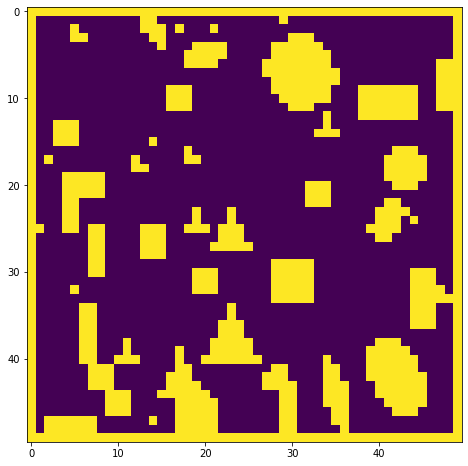

In [6]:
import matplotlib.pyplot as plt

x = logs["tasks"][0]
show_maze(x)

In [7]:
import argparse
parser = argparse.ArgumentParser(
    description='Reinforcement learning with Model-Agnostic Meta-Learning (MAML) - Test')

args = {
"config": "../maml-randomShapeMaze/config.json",
"policy": "../maml-randomShapeMaze/policy.th",

# Evaluation
"num_batches": 1,
"meta_batch_size": 1,

# Miscellaneous
"output": "maml-randomShapeMaze/results.npz",
"seed": None,
"num_workers": 1,
"device": ('cpu'),
}

height = 50
width = 50

In [8]:
try:
    gym.envs.register(
        id="RandomShapeMaze-v0",
        entry_point=MazeEnv,
        max_episode_steps=200,
        kwargs={"width": 50, "height": 50, "max_shapes": 50,
                "max_size": 8, "allow_overlap": False, "shape": None}
    )
except:
    print("environment already registered")

In [9]:
with open(args["config"], 'r') as f:
    config = json.load(f)
    if 'env-kwargs' not in config.keys(): config['env-kwargs'] = {}

env = gym.make(config['env-name'], **config['env-kwargs'])
env.close()

# configs:
fast_lr = config["fast-lr"]

In [10]:
def get_policy(policy_path):
    policy = get_policy_for_env(env,
                                hidden_sizes=config['hidden-sizes'],
                                nonlinearity=config['nonlinearity'])
    with open(policy_path, 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device(args["device"]))
        policy.load_state_dict(state_dict)
    return policy
        
policy = get_policy(args["policy"])

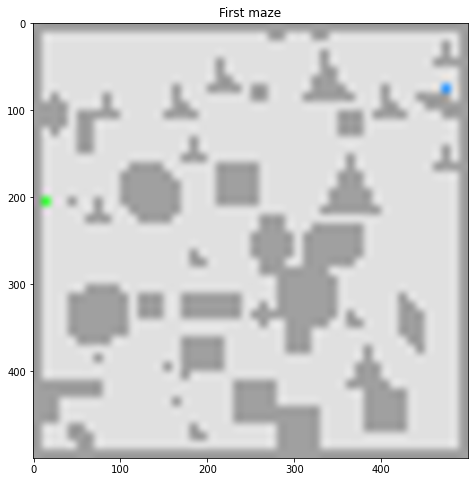

In [11]:
observations = env.reset()
img = env.render('rgb_array')
show_maze(img, "First maze")

In [12]:
def run_policy(env, observations=None):
    if observations.all == None:
        observations = env.reset()
    data = []
    path = [env.maze.objects.agent.positions[0]]
    count = 0
    reward = 0
    with torch.no_grad():
        while not (env.maze.objects.agent.positions == env.maze.objects.goal.positions) and count < 200:
            observations_tensor = torch.from_numpy(observations)
            pi = policy(observations_tensor) #, params=params)
            actions_tensor = pi.sample()
            actions = actions_tensor.cpu().numpy()

            new_observations, rewards, _, infos = env.step(actions)

            data.append({ "observations": observations, "actions": actions, "rewards": rewards })
            observations = new_observations
            path.append(env.maze.objects.agent.positions[0])
            count += 1
            reward += rewards
    return data, np.array(path), reward

In [13]:
def show_policy(env, title):
    observations = env.reset()
    maze_original = observations.reshape(height,width)
    data, path, reward = run_policy(env, observations)

    maze_original[path[:,0], path[:,1]] = 4
    maze_original[path[0,0], path[0,1]] = 2
    maze_original[path[-1,0], path[-1,1]] = 3
    show_maze(maze_original, title + " - reward = {0}".format(round(reward, 2)))

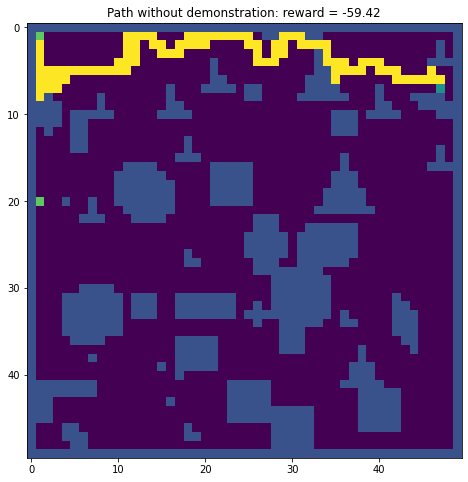

In [14]:
maze_original = observations.reshape(height,width)
data, path, reward = run_policy(env, observations)

maze_original[path[:,0], path[:,1]] = 4
maze_original[path[0,0], path[0,1]] = 2
maze_original[path[-1,0], path[-1,1]] = 3
show_maze(maze_original, "Path without demonstration: reward = {0}".format(round(reward, 2)))

## Update with example:

In [15]:
class Episodes:
    def __init__(self, batch_size, actions, rewards, observations):
        self.batch_size = batch_size
        self.actions = actions
        self.rewards = rewards
        self.observations = observations
        self.observation_shape = observations.shape[2:]
        self._lengths = None
        
    @property
    def lengths(self):
        if self._lengths is None:
            self._lengths = [len(rewards) for rewards in self.rewards]
        return self._lengths
    
    def __len__(self):
        return max(self.lengths)

In [16]:
def train_iter(policy):
    observations = env.reset()
    impassable_array = env.unwrapped.maze.to_impassable()
    motions = env.unwrapped.motions
    start = env.unwrapped.maze.objects.agent.positions[0]
    goal = env.unwrapped.maze.objects.goal.positions[0]
    actions = dijkstra_solver(impassable_array, motions, start, goal)
    rewards = []
    observations = []
    for action in actions:
        observation, reward, _, infos = env.step(action)
        rewards.append(reward)
        observations.append(observation)
        
    actions      = torch.tensor([actions])
    rewards      = torch.tensor([rewards])
    observations = torch.tensor([observations])
    
    episodes = Episodes(1, actions, rewards, observations)
    
    params = None
    loss = reinforce_loss(policy, episodes, params=params)
    params = policy.update_params(loss,
                                  params=params,
                                  step_size=fast_lr,
                                  first_order=True)

In [17]:
train_iter(policy)

## Check outcome after 1 iteration:

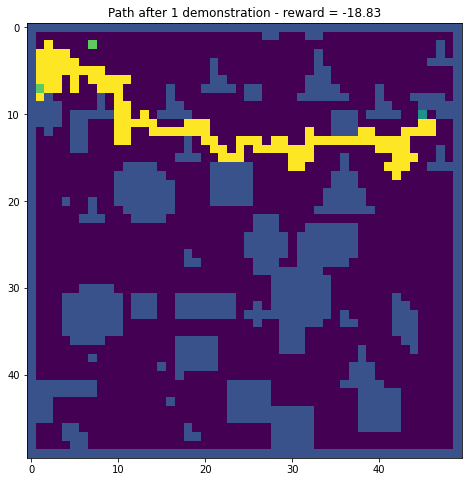

In [18]:
show_policy(env, "Path after 1 demonstration")

## After 20 iterations

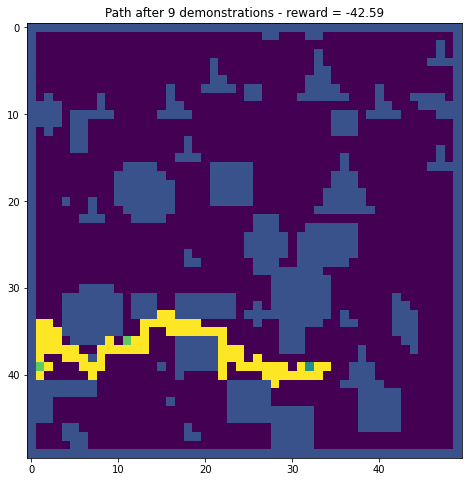

In [21]:
for ii in range(19):
    train_iter(policy)

show_policy(env, "Path after 9 demonstrations")